# Essential dynamics

In [1]:
import torch
import pickle
from torch.utils.data import DataLoader

from devinterp.slt.forms import *


plt.rcParams["figure.dpi"] = 300

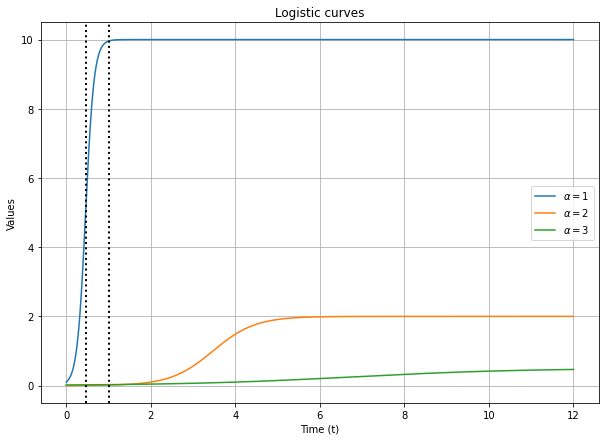

Processing smoothing for PC1
Processing smoothing for PC2
Processing smoothing for PC3
Number of samples: 5000
Plotting PC1 vs PC2
Plotting PC1 vs PC3
Plotting PC2 vs PC3


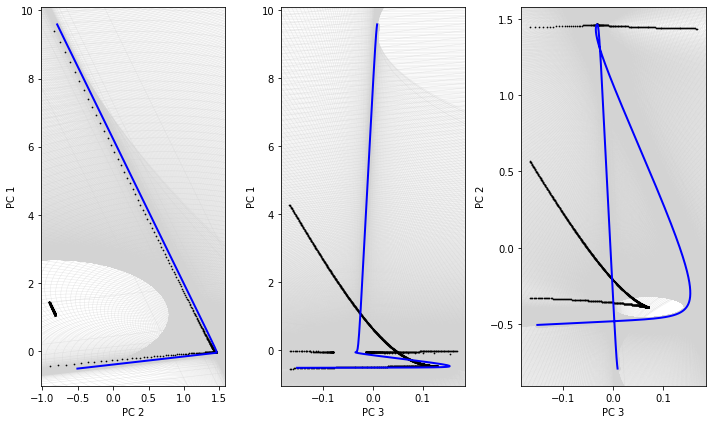

In [2]:
def create_timeseries(s, a, delta, t_range):
    """
    Create a timeseries of 3D vectors based on the given parameters.

    Parameters:
    - s: Tuple or list of s parameters (s_1, s_2, s_3)
    - a: Tuple or list of a parameters (a_1, a_2, a_3)
    - t_range: Array of time values over which to compute the coordinates

    Returns:
    - A numpy array of shape (len(t_range), 3) containing the 3D vectors for each time t
    """
    # Preallocate the array
    timeseries = np.zeros((len(t_range), 3))

    # Compute the coordinates for each time t
    for i, t in enumerate(t_range):
        for j in range(3):
            timeseries[i, j] = (
                s[j]
                * np.exp(s[j] * (t - delta[j]))
                / (np.exp(s[j] * (t - delta[j])) - 1 + s[j] / a[j])
            )

    return timeseries


s = (3.0, 2.0, 1.0)  # s_1, s_2, s_3
s = (10.0, 2.0, 0.5)  # s_1, s_2, s_3
a = (0.1, 0.1, 0.1)  # a_1, a_2, a_3
delta = (0.0, 2.0, 4.0)
num_steps = 5000
t_range = np.linspace(0, 12, num_steps)  # Time range from 0 to 1 with 100 steps

timeseries = create_timeseries(s, a, delta, t_range)

marked_cusp_data = [
    {"step": 197, "influence_start": 190, "influence_end": 210},
    {"step": 425, "influence_start": 390, "influence_end": 450},
]
# { "step" : 498, "influence_start" : 450, "influence_end" : 550 }]

# Plotting
plt.figure(figsize=(10, 7), facecolor="white")
plt.plot(t_range, timeseries[:, 0], label=r"$\alpha = 1$")
plt.plot(t_range, timeseries[:, 1], label=r"$\alpha = 2$")
plt.plot(t_range, timeseries[:, 2], label=r"$\alpha = 3$")
plt.axvline(
    marked_cusp_data[0]["step"] / num_steps * 12, color="black", linestyle=":", lw=2
)
plt.axvline(
    marked_cusp_data[1]["step"] / num_steps * 12, color="black", linestyle=":", lw=2
)

plt.xlabel("Time (t)")
plt.ylabel("Values")
plt.title("Logistic curves")
plt.legend()
plt.grid(True)
plt.show()

n_pca_components = 3
pca = PCA(n_components=n_pca_components)
transformed_samples = pca.fit_transform(timeseries)
smoothed_pcs = get_smoothed_pcs(
    transformed_samples,
    n_pca_components,
    early_smoothing=1,
    late_smoothing=1,
    late_smoothing_from=1,
)

fig = plot_essential_dynamics_grid(
    transformed_samples,
    smoothed_pcs,
    num_plotted_pca_comps=n_pca_components,
    plot_caustic=True,
    # marked_cusp_data=marked_cusp_data,
    figsize=(10, 6),
    num_sharp_points=0,
    num_vertices=0,
    osculate_start=1,
    osculate_end_offset=0,
    osculate_skip=1,
)

plt.tight_layout()
plt.show()

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
models = torch.load(f"model1.pt", map_location=DEVICE)

In [4]:
BATCH_SIZE = 1024
dataset = torch.load("ED_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
outputs = get_output_for_models(models, dataloader, device=DEVICE)
print(len(outputs))
# 190 checkpoints is too few, too bad. otherwise we'd run form analysis on `outputs`, like for `timeseries` above  

190


Processing smoothing for PC1
Processing smoothing for PC2
Processing smoothing for PC3
Explained variance of PCA
[0.5630448  0.15191932 0.0681259  0.0370252 ]
len(colors) != len(transitions), using rainbow palette.
Number of samples: 5000
Plotting PC1 vs PC2


/home/paperspace/devinterp/src/devinterp/slt/forms.py:109: UserWarning: Can't plot vertex influence when cusp data not provided
  warnings.warn("Can't plot vertex influence when cusp data not provided")


Plotting PC1 vs PC3
Plotting PC2 vs PC3


/home/paperspace/devinterp/src/devinterp/slt/forms.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


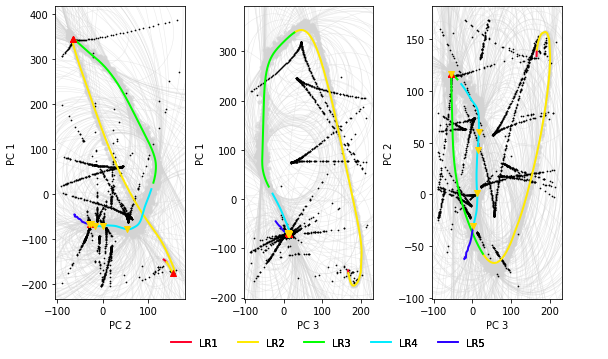

In [6]:
TRANSITIONS = [  # TODO automate
    (0, 10, "LR1"),
    (10, 400, "LR2"),
    (400, 1_200, "LR3"),
    (1_260, 3_000, "LR4"),
    (3_000, 5_000, "LR5"),
]

# The marked cusps were discovered by the automated vertex discovery and visual inspection,
# while the influence regions are based on analysing the distance functions
marked_cusp_data = [  # TODO automate
    {"idx": 25, "influence_start": 18, "influence_end": 26},
    {"idx": 345, "influence_start": 300, "influence_end": 400},
    {"idx": 1_061, "influence_start": 900, "influence_end": 1_250},
    {"idx": 1_689, "influence_start": 1_500, "influence_end": 1_900},
]

ED_FILENAME = "ED-LR-seed1.pkl"
with open(ED_FILENAME, "rb") as file:
    pca, transformed_samples = pickle.load(file)

n_pca_components = 3
smoothed_pcs = get_smoothed_pcs(
    transformed_samples,
    n_pca_components,
    early_smoothing=1,
    late_smoothing=60,
    late_smoothing_from=200,
)

print("Explained variance of PCA")
print(pca.explained_variance_ratio_)

fig = plot_essential_dynamics_grid(
    transformed_samples,
    smoothed_pcs,
    transitions=TRANSITIONS,
    # marked_cusp_data=marked_cusp_data,
    num_plotted_pca_comps=n_pca_components,
    plot_vertex_influence=True,
    plot_caustic=True,
    figsize=(8, 8 / 10 * 6),
    num_sharp_points=5,
    num_vertices=5,
    osculate_start=1,
    osculate_end_offset=2000,
    osculate_skip=8,
)
plt.show()